In [2]:
""" If you haven't already, run the following commands on the commandline (perhaps using pip or pip3): """
%pip install numpy
%pip install scipy
%pip install seaborn
%pip install moviepy
%pip install gym

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\decorator.cpython-39.pyc'
Consider using the `--user` option or check the permissions.




  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=a5efcb8468599977b69a2cf26403fba6256cb0a0a189bc20c0d97144c2aba162
  Stored in directory: c:\users\tirth\appdata\local\pip\cache\wheels\29\15\e4\4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import scipy
from scipy.io import loadmat
from scipy.io import savemat
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from utils import *
from envs.cart_pole_env import CartPoleEnv

# Part 1 [2.5 pt] - Linear System
We start with the linear system and we consider optimizing for a sequence of actions using shooting (an optimization technique for model-predictive control problems.)

The linear system optimal control problem may be written in the following form:

$$\min_{x,u} \sum_{t=0}^{T-1} (x_t' Q x_t + u_t' R u_t) + x_{T}' Q_{final} x_{T} \\ \text{s.t. }x_{t+1} = A x_t + B u_t$$

Note that this is a purely linear system $x_{t+1} = f(x) = A x_t + B u_t$, where $A$ and $B$ are matrices, with a quadratic cost function $c(x_0,u_0) = \sum_{t=0}^{T-1} (x_t' Q x_t + u_t' R u_t) + x_{T}' Q_{final} x_{T}$, where $R$, $Q$, and $Q_{final}$ are also matrices.

First, we define the environment:

In [7]:
class LinearEnv(object):
    def __init__(self, horizon=20, multiplier=1.):
        self.A = multiplier * 0.1 * np.array([[0.0481, -0.5049, 0.0299, 2.6544, 1.0608],
                                 [2.3846, -0.2312, -0.1260, -0.7945, 0.5279],
                                 [1.4019, -0.6394, -0.1401, 0.5484, 0.1624],
                                 [-0.0254, 0.4595, -0.0862, 2.1750, 1.1012],
                                 [0.5172, 0.5060, 1.6579, -0.9407, -1.4441]])
        self.B = np.array([[-0.7789, -1.2076],
                           [0.4299, -1.6041],
                           [0.2006, -1.7395],
                           [0.8302, 0.2295],
                           [-1.8465, 1.2780]])
        self.H = 20 # the time horizon

        self.dx = self.A.shape[1]
        self.du = self.B.shape[1]
        self.Q = np.eye(self.dx)
        self.R = np.eye(self.du)
        self._init_state =  np.array([-1.9613, -1.3127, 0.0698, 0.0935, 1.2494])
        self.reset()

    def step(self, act):
        # recall that @ means matrix multiply in NumPy
        cost = self._state.T @ self.Q @ self._state + act.T @ self.R @ act
        state = self.A @ self._state + self.B @ act
        self._state = state.copy()
        return state, cost, False, {}

    def set_state(self, state):
        self._state = state.copy()

    def reset(self):
        self._state = self._init_state.copy()
        return self._init_state.copy()

In [37]:
env = LinearEnv() # m

Now, we implement the non-linear optimization algorithm using shooting. A correct implementation should give an optimal cost of 7.461.

## [2 pt] Shooting

In the shooting method, we look for the sequences of actions that minimizes the total cost by directly substuting the constraints in the objective:

$$ \min_{u_0, \dots, u_H} c(x_0, u_0) + c(f(x_0, u_0), u_1) + c(f(f(x_0, u_0), u_1),u_2) + \cdots $$

That is, as can be observed above, shooting takes the state and control $(x_t,u_t)$ and uses it to calculate the next state $x_{t+1}$ by directly applying the equations of motion $f(x,u)$, at which point $u_{t+1}$ is selected in order to minimize the objective.

In order to perform the optimization, we need to define the objective function to optimize.
Fill in the code in ```eval_shooting``` which should return the cost of the trajectory
with the specified sequences of actions.

In [38]:
def eval_shooting(actions,env):
    """
    Find the cumulative cost of the sequences of actions, which has shape [horizon, action dimension].
    Use the function step of the environment: env.step(action). It returns: next_state, cost, done,
    env_infos.
    """
    state = env.reset()
    actions = actions.reshape(env.H, env.du)
    horizon = env.H
    
    total_cost = 0

    
    """YOUR CODE HERE"""
    """HINT: Look at the step function in previous cells to do this"""
    for A in actions:
        state_n,cost_n,var1,var2=env.step(A)
        total_cost+=cost_n
    """YOUR CODE ENDS HERE"""
    return total_cost

Once we have defined the objective function, we can use an off-the-shelf optimizer 
to find the optimal actions. In these case, we use 
[BFGS](https://docs.scipy.org/doc/scipy-0.16.0/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs),
which is a quasi-Newton method.

In [39]:
def minimize_shooting(env, init_actions=None):
    if init_actions is None:
        init_actions = np.random.uniform(low=-.1, high=.1, size=(env.H * env.du,))
    """YOUR CODE HERE"""
    res = minimize(fun=eval_shooting,# Fill this with a function that returns the cumulative cost given the states and actions
               x0=init_actions,# Fill this with the inital actions
               args=(env),
               method='BFGS',
               options={'xtol': 1e-6, 'disp': False, 'verbose': 2}
              )

    act_shooting = res.x
    print(res.message)
    print("The optimal cost is %.3f" % res.fun)
    policy_shooting = ActPolicy(env=env, 
                                actions=act_shooting
                               )
    return policy_shooting
"""YOUR CODE ENDS HERE"""

policy_shooting = minimize_shooting(env)

Optimization terminated successfully.
The optimal cost is 7.461


### Evaluation

---- Quantitative Metrics ---
Shooting Cost 7.461


---- Qualitative Metrics ---
Evolution of the value of each dimension across 20 timesteps for the shooting method.
This method converges to the origin. Shooting: solid line(-)


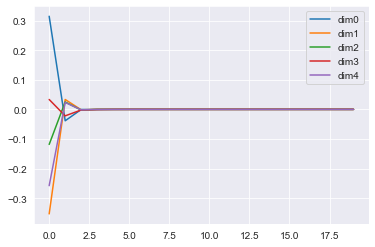

In [40]:
cost_shoot, states_shoot = rollout(env, policy_shooting)
states_shoot=np.array(states_shoot)
ts = np.arange(states_shoot.shape[0])
print("---- Quantitative Metrics ---")
print("Shooting Cost %.3f" % cost_shoot)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of each dimension across 20 timesteps for the shooting method.")
print("This method converges to the origin. Shooting: solid line(-)")
legend_=[f'dim{i}' for i in range(env.dx)]
for i in range(env.dx):
    plt.plot(ts, states_shoot[:, i], '-')
    plt.legend(legend_)

## [0.5 pt] Theoretical Question
Consider the linear system that we currently have, i.e., $$x_{t+1} = Ax_t + B u_t$$
and we want to minimize the quadratic cost $$ \frac{1}{2}\sum_t x_t^{T} Q x_t$$
Hence, we have a linear quadratic regulator problem. Derive the gradient update for the action variables for the shooting method.

Explain in a few lines why the shooting method might become unstable.

## [0 pt] Empirical Behaviour

Now, we test the effect that you derived and see if the theory matches the empirical behavior. We use the same environment as in the previous part, but we just scale the transiton matrix so it has some eigenvalues larger than 1. Note this is the only change with respect to the previous part.

In [41]:
env = LinearEnv(multiplier=10.)
np.abs(np.linalg.eigvals(env.A))

array([2.60524128, 1.46066843, 1.46066843, 0.97434961, 0.97434961])

### Shooting

In [42]:
policy_shooting = minimize_shooting(env)

Desired error not necessarily achieved due to precision loss.
The optimal cost is 72273164601128.156


### Evaluation

---- Quantitative Metrics ---
Shooting Cost 72273164601128.156


---- Qualitative Metrics ---
Evolution of the value of each dimension across 20 timesteps for the shooting methods.
The shooting method diverges. Shooting: solid line(-).


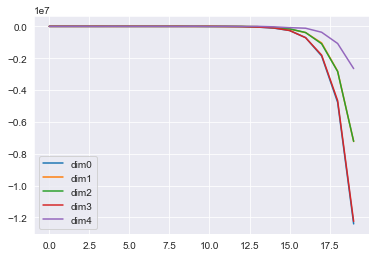

In [43]:
cost_shoot, states_shoot = rollout(env, policy_shooting)
states_shoot=np.array(states_shoot)
print("---- Quantitative Metrics ---")
print("Shooting Cost %.3f" % cost_shoot)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of each dimension across 20 timesteps for the shooting methods.")
print("The shooting method diverges. Shooting: solid line(-).")
ts = np.arange(states_shoot.shape[0])
legend_=[f'dim{i}' for i in range(env.dx)]
for i in range(env.dx):
    plt.plot(ts, states_shoot[:, i], '-')
    plt.legend(legend_)

# Part 2 [2.5 pt] - Open-loop vs. Closed-loop
Until now, we have been optimizing directly the sequences of actions and then applying each of the actions in the sequences "blindly". While this suffices in deterministic environments, in the presence of noise it does not work out well usually. Because of the stochastic transitions, the state that you encounter at a specific time-step differs from the one predicted by the optimzation problem; as a result, the action found is no longer valid. In stochastic environments, we need close loop controllers in the form of either (i) parametric policies (e.g. linear feedback controllers or neural-networks), or (ii) non-parametric policies (e.g. model predictive control).

In the following, we will compare the different behaviour of open-loop and closed-loop control methods. Use the optimal cost for the action optimization methods to check the validity of your implementation.

In [44]:
env = CartPoleEnv()

## Action Optimization

In [45]:
action_shooting = minimize_shooting(env)

Optimization terminated successfully.
The optimal cost is 0.008


## [1 pt] Policy Optimization

We will start by learning a neural network policy using a shooting method. Fill in the code for ``eval_policy``.

In [52]:
def eval_policy(env, policy, params):
    """
    Find the cost the policy with parameters params.
    Use the function step of the environment: env.step(action). It returns: next_state, cost, done,
    env_infos.
    
    You can set the parameters of the policy by policy.set_params(params) and get the action for the current state
    with policy.get_action(state).
    """
    state = env.reset()
    total_cost = 0
    horizon = env.H
    policy.set_params(params)
    """YOUR CODE HERE"""
    for _ in range(horizon):
        action=policy.get_action(state)
        state_n,cost_n,var1,var2=env.step(action)
        state=state_n
        total_cost+=cost_n
    """YOUR CODE ENDS HERE"""
    return total_cost

In [53]:
def minimize_policy_shooting(env):
    policy_shooting = NNPolicy(env.dx, env.du, hidden_sizes=(10, 10))
    policy_shooting.init_params()
    params = policy_shooting.get_params()

    res = minimize(lambda x: eval_policy(env, policy_shooting, x),
                   params,
                   method='BFGS',
                   options={'xtol': 1e-6, 'disp': False, 'verbose': 2})
    print(res.message)
    print("The optimal cost is %.3f" % res.fun)
    params_shooting = res.x
    policy_shooting.set_params(params_shooting)
    return policy_shooting

policy_shooting = minimize_policy_shooting(env)

Optimization terminated successfully.
The optimal cost is 0.008


## [1 pt] Model Predictive Control

In [48]:
class MPCPolicy(object):
    def __init__(self, env, horizon):
        self.env = env
        self.H = horizon
        self.env = copy.deepcopy(env)
        np.random.seed(1)
        self.init_actions = np.random.uniform(low=-.1, high=.1, size=(horizon * env.du,))
        
    def get_action(self, state, timestep):
        """
        Find the cost of the sequences of actions and state that have shape [horizon, action dimension]
        and [horizon, state_dim], respectively.
        Use the function step of the environment: env.step(action). It returns, next_state, cost, done,
        env_infos.

        In order to set the environment at a specific state use the function self.env.set_state(state)
        """
        env = self.env
        horizon = min(self.H, env.H - timestep)
        
        def eval_mpc(actions, state):
            actions = actions.reshape(horizon, env.du)
            total_cost = 0
            """YOUR CODE HERE"""
            self.env.set_state(state)
            for _ in range(horizon):
                state_n,cost_n,var1,var2=self.env.step(actions[_])
                total_cost+=cost_n 
            """YOUR CODE ENDS HERE"""
            return total_cost

        self.init_actions = np.random.uniform(low=-.1, high=.1, size=(horizon * env.du,))
        res = minimize(lambda x: eval_mpc(x, state),
               self.init_actions, 
               method='BFGS',
               options={'xtol': 1e-6, 'disp': False, 'verbose': 2}
              )
        act_shooting = res.x
        return act_shooting[:env.du]
        

    def reset(self):
        pass

In [49]:
mpc_policy = MPCPolicy(env, env.H)

## Evaluation
### No noise

---- Quantitative Metrics ---
Action Cost 0.008
Policy Cost 0.008
MPC Cost 0.008


---- Qualitative Metrics ---
Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.
All the approaches achieve the same cost and follow the same trajectory. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)


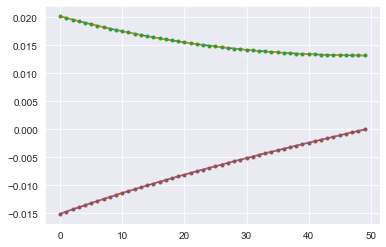

In [54]:
noise = 0.
cost_act, states_act = rollout(env, action_shooting, noise)
cost_pi, states_pi = rollout(env, policy_shooting, noise)
cost_mpc, states_mpc = rollout(env, mpc_policy, noise)
states_act, states_pi, states_mpc = np.array(states_act), np.array(states_pi), np.array(states_mpc)
print("---- Quantitative Metrics ---")
print("Action Cost %.3f" % cost_act)
print("Policy Cost %.3f" % cost_pi)
print("MPC Cost %.3f" % cost_mpc)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.")
print("All the approaches achieve the same cost and follow the same trajectory. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)")
ts = np.arange(states_act.shape[0])
plt.plot(ts, states_act[:, 2], '-', ts, states_pi[:, 2], '--', states_mpc[:, 2], '.')
plt.plot(ts, states_act[:, 3], '-', ts, states_pi[:, 3], '--', states_mpc[:, 3], '.')
plt.show()

### Noise

---- Quantitative Metrics ---
Action Cost 4544.439
Policy Cost 331.152
MPC Cost 55.286


---- Qualitative Metrics ---
Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.
In the presence of noise, the open-loop controller fails to stablize the pole, while the policy and mpc controller succeed. The MPC approach achieves the best performance. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)


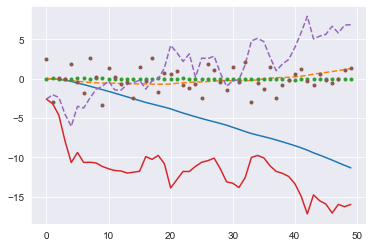

In [55]:
noise = 1.
cost_act, states_act = rollout(env, action_shooting, noise)
cost_pi, states_pi = rollout(env, policy_shooting, noise)
cost_mpc, states_mpc = rollout(env, mpc_policy, noise)
states_act, states_pi, states_mpc = np.array(states_act), np.array(states_pi), np.array(states_mpc)
print("---- Quantitative Metrics ---")
print("Action Cost %.3f" % cost_act)
print("Policy Cost %.3f" % cost_pi)
print("MPC Cost %.3f" % cost_mpc)

print("\n\n---- Qualitative Metrics ---")
print("Evolution of the value of the angle and angular velocity of the cart-pole environment across 50 timesteps for the open-loop, policy controller, and mpc controller.")
print("In the presence of noise, the open-loop controller fails to stablize the pole, while the policy and mpc controller succeed. The MPC approach achieves the best performance. Open-loop: solid line(-);  Policy: dashed line(--). MPC: dotted line(.)")
ts = np.arange(states_act.shape[0])
plt.plot(ts, states_act[:, 2], '-', ts, states_pi[:, 2], '--', states_mpc[:, 2], '.')
plt.plot(ts, states_act[:, 3], '-', ts, states_pi[:, 3], '--', states_mpc[:, 3], '.')
plt.show()

Why does the MPC method perform better than having a policy?
Is there anyway we could make the performance of the policy better?

Reply in no more than 5 lines in the box below.

## [0.5 pt] Response: